# Data
- movie_ratings_500_id.pkl contains the interactions between users and movies
- movie_metadata.pkl contains detailed information about movies, e.g. genres, actors and directors of the movies.

# Goal
- Compare the performances of different recommender systems
- Construct your own recommender systems


# Baselines

## User-Based Collaborative Filtering
This approach predicts $\hat{r}_{(u,i)}$ by leveraging the ratings given to $i$ by $u$'s similar users. Formally, it is written as:

\begin{equation}
\hat{r}_{(u,i)} = \frac{\sum\limits_{v \in \mathcal{N}_i(u)}sim_{(u,v)}r_{vi}}{\sum\limits_{v \in \mathbf{N}_i(u)}|sim_{(u,v)}|}
\end{equation}
where $sim_{(u,v)}$ is the similarity between user $u$ and $v$. Usually, $sim_{(u,v)}$ can be computed by Pearson Correlation or Cosine Similarity.

## Item-Based Collaborative Filtering
This approach exploits the ratings given to similar items by the target user. The idea is formalized as follows:

\begin{equation}
\hat{r}_{(u,i)} = \frac{\sum\limits_{j \in \mathcal{N}_u(i)}sim_{(i,j)}r_{ui}}{\sum\limits_{j \in \mathbf{N}_u(i)}|sim_{(i,j)}|}
\end{equation}
where $sim_{(i,j)}$ is the similarity between item $i$ and $j$. Usually, $sim_{(i,j)}$ can be computed by Pearson Correlation or Cosine Similarity.

## Vanilla MF
Vanilla MF is the inner product of vectors that represent users and items. Each user is represented by a vector $\textbf{p}_u \in \mathbb{R}^d$, each item is represented by a vector $\textbf{q}_i \in \mathbb{R}^d$, and $\hat{r}_{(u,i)}$ is computed by the inner product of $\textbf{p}_u $ and $\textbf{q}_i$. The core idea of Vanilla MF is depicted in the followng figure and follows the idea of SVD as we have seen during the TD.

![picture](https://drive.google.com/uc?export=view&id=1EAG31Qw9Ti6hB7VqdONUlijWd4rXVobC)

\begin{equation}
\hat{r}_{(u,i)} = \textbf{p}_u{\textbf{q}_i}^T
\end{equation}

## Some variants of SVD


-  SVD with bias: $\hat{r_{ui}} = \mu + b_u + b_i + {q_i}^Tp_u$
- SVD ++: $\hat{r_{ui}} = \mu + b_u + b_i + {q_i}^T(p_u + |I_u|^{\frac{-1}{2}}\sum\limits_{j \in I_u}y_j)$

## Factorization machine (FM)

FM takes into account user-item interactions and other features, such as users' contexts and items' attributes. It captures the second-order interactions of the vectors representing these features , thereby enriching FM's expressiveness. However, interactions involving less relevant features may introduce noise, as all interactions share the same weight. e.g. You may use FM to consider the features of items.

\begin{equation}
\hat{y}_{FM}(\textbf{X}) = w_0 + \sum\limits_{j =1}^nw_jx_j + \sum\limits_{j=1}^n\sum\limits_{k=j+1}^n\textbf{v}_j^T\textbf{v}_kx_jx_k
\end{equation}

where $\textbf{X} \in \mathbb{R}^n$ is the feature vector, $n$ denotes the number of features, $w_0$ is the global bias, $w_j$ is the bias of the $j$-th feature and $\textbf{v}_j^T\textbf{v}_k$ denotes the bias of interaction between $j$-th feature and $k$-th feature, $\textbf{v}_j \in \mathbb{R}^d$ is the vector representing $j$-th feature.

## MLP

You may also represent users and items by vectors and them feed them into a MLP to make prediction.

## Metrics

- $\begin{equation}
RMSE = \sqrt{\frac{1}{|\mathcal{T}|}\sum\limits_{(u,i)\in\mathcal{T}}{(\hat{r}_{(u,i)}-r_{ui})}^2}
\end{equation}$

- $\begin{equation}
MAE = \frac{1}{|\mathcal{T}|}\sum\limits_{(u,i)\in\mathcal{T}}{|\hat{r}_{(u,i)}-r_{ui}|}
\end{equation}$
-  Bonnus: you may also consider NDCG and HR under the top-k setting


# Requirements
- Try to compare different methods that you have adopted and interpret the results that you have obtained
- Minizing the RMSE and MAE
- Construct a recommender system that returns the top 10 movies *that the user have not viewed yet*.

# Our work

## Step 1 : Import the data

We create a class Data with several methods. The goal here is to centralize the data processing to obtain the relevant dataframes we need to process our data with scikit surprise.

In [2]:
import pandas as pd

class Data:

    metadata:dict
    ratings:dict
    user_ratings:dict
    ratings_df:pd.DataFrame
    metadata_df:pd.DataFrame
    merged_df:pd.DataFrame
    
    def __init__(self, metadata_path:str, ratings_path:str):
        self.metadata = pd.read_pickle(metadata_path)
        self.ratings = pd.read_pickle(ratings_path)
        self.user_ratings = self.get_user_ratings()
        self.ratings_df = self.get_ratings_as_df()
        self.metadata_df = self.get_metadata_as_df()
        self.merged_df = pd.merge(self.ratings_df, self.metadata_df, left_on='movie_id', right_on='movie_id')

    def get_user_ratings(self)->dict:
        output = {}
        for k, array in self.ratings.items():
            for v in array:
                user_movie = {
                    'user_rating': int(v['user_rating']),
                    'movie_id': k
                }
                user_id = v['user_id']

                if user_id in output.keys():
                    output[int(user_id)].append(user_movie)
                else:
                    output[int(user_id)] = [user_movie]
        return output

    def get_ratings_as_df(self)->pd.DataFrame:
        output = []

        for film, rating in self.ratings.items():
            for index in rating:
                index['movie_id'] = film
                del index['user_rating_date']
                output.append(index)
    
        return pd.DataFrame(output)
    
    def get_metadata_as_df(self)->pd.DataFrame:
        output = []

        for movie_id, movie_data in self.metadata.items():
            movie_data['genre'] = ",".join(movie_data['genre'])
            movie_data['actors'] = ",".join(movie_data['actors'])
            output.append({'movie_id': movie_id, **movie_data})

        return pd.DataFrame(output)
    
data = Data(
    metadata_path='movie_metadata.pkl', 
    ratings_path='movie_ratings_500_id.pkl'
)

data.merged_df

,user_rating,user_id,movie_id,director,genre,actors,title
0,4,1380819,tt0305224,Peter Segal,Comedy,"Jack Nicholson,Adam Sandler,Marisa Tomei,Woody...",Anger Management
1,3,185150,tt0305224,Peter Segal,Comedy,"Jack Nicholson,Adam Sandler,Marisa Tomei,Woody...",Anger Management
2,4,1351377,tt0305224,Peter Segal,Comedy,"Jack Nicholson,Adam Sandler,Marisa Tomei,Woody...",Anger Management
3,2,386143,tt0305224,Peter Segal,Comedy,"Jack Nicholson,Adam Sandler,Marisa Tomei,Woody...",Anger Management
4,3,2173336,tt0305224,Peter Segal,Comedy,"Jack Nicholson,Adam Sandler,Marisa Tomei,Woody...",Anger Management
...,...,...,...,...,...,...,...
259813,5,1139877,tt0361862,Brad Anderson,"Drama,Thriller","Christian Bale,Jennifer Jason Leigh,Aitana Sán...",The Machinist
259814,4,1460015,tt0361862,Brad Anderson,"Drama,Thriller","Christian Bale,Jennifer Jason Leigh,Aitana Sán...",The Machinist
259815,5,1098265,tt0361862,Brad Anderson,"Drama,Thriller","Christian Bale,Jennifer Jason Leigh,Aitana Sán...",The Machinist
259816,4,1962894,tt0361862,Brad Anderson,"Drama,Thriller","Christian Bale,Jennifer Jason Leigh,Aitana Sán...",The Machinist


# Step 2 : Obtain the movies that a user haven't viewed yet

## Creation of a base recommender class
Our goal is to create a base class that implements 3 methods: train, test and evaluate. Train will be overridden by a superclass (one for each recommender we want to test). Test and evaluate can be overidden or not, depending on the context. It has several attributes that are useful when it comes to training a model with the data we've got earlier.

In [3]:
from surprise import AlgoBase, Dataset, Prediction, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# We first create a class that will be used as a base to all the other recommender class we will create

class BaseRecommender:
    model_data:Dataset
    df:pd.DataFrame
    train_set:Dataset
    test_set:Dataset
    model:AlgoBase
    predictions:list[Prediction]

    def __init__(
        self, 
        df:pd.DataFrame=data.merged_df[['user_id', 'movie_id', 'user_rating']], 
        test_size:float=0.2, 
        random_state:int=42
    ):
        self.df = df
        self.model_data = Dataset.load_from_df(df, Reader(rating_scale=(1, 5)))
        self.train_set, self.test_set = train_test_split(self.model_data, test_size=test_size, random_state=random_state)

    def train(self)->None:
        pass

    def test(self, update:bool=True)->list[Prediction]:
        predictions = self.model.test(self.test_set)
        if update:
            self.predictions = predictions
        return predictions
    
    def predict(self, user_id: int | str, item_id: str) -> float:
        if isinstance(user_id, int):
            user_id = str(user_id)

        # We get the row where the user and movie are both referenced, if it exists
        user_movie_rating = self.df[
            (self.df['user_id'] == user_id) & (self.df['movie_id'] == item_id)
        ]

        if not user_movie_rating.empty:
            actual_rating = user_movie_rating['user_rating'].values[0]
            return float(actual_rating)
        else:
            return self.model.predict(user_id, item_id).est
    
    def get_top_movies_for_user(self, user_id: int | str, n: int = 10) -> pd.DataFrame:
        if isinstance(user_id, int):
            user_id = str(user_id)

        # List of already watched movies
        watched_movies = set(self.df[self.df['user_id'] == int(user_id)]['movie_id'])

        all_movies = set(self.df['movie_id'])
        candidate_movies = list(all_movies - watched_movies)

        # We generate predictions for all movies that the user haven't watched yet (candidates)
        predictions = [(user_id, movie_id, self.model.predict(user_id, movie_id).est) for movie_id in candidate_movies]
        sorted_predictions = sorted(predictions, key=lambda x: x[2], reverse=True)

        # We select the top N movies
        top_n_movies = sorted_predictions[:n]

        # We create a DataFrame with the results
        result_df = pd.DataFrame(top_n_movies, columns=['user_id', 'movie_id', 'estimated_rating'])

        return result_df
    
    def evaluate(self)->pd.DataFrame:
        assert self.predictions is not None
        assert len(self.predictions) >= 0
        return pd.DataFrame([{
            'model': self.__class__.__name__,
            'rmse': accuracy.rmse(self.predictions, verbose=False),
            'mae': accuracy.mae(self.predictions, verbose=False)
        }])


## Analysis of several models and parameters

1. User-based collaborative filtering
   - With cosine
   - With Pearson
2. Item-based collaborative filtering
   - With cosine
   - With Pearson

We use the KNNBasic model for this approach because it is the most relevant model for collaborative filtering. Its native support of cosine/pearson and user/item base as parameters makes it a relevant choice for calculating metrics.

In order to integrate the full range of data points we have at our disposal, we provide the model with two similarity functions with the goal of leveraging directors, genres, and actors in the process. It is worth noting that the latter two, when plural, are comma-separated in a single string. The use of isin(), as shown in the above functions, is relevant because the presence of all the data in one field allows a simpler similarity analysis than another table with joins or similars.

In [4]:
from surprise import KNNBasic
# We create and instanciate a first recommender system with the User-Based or Item-based Collaborative Filtering method

class CollaborativeFiltering(BaseRecommender):
    model:KNNBasic
    similarity_method:str
    user_based:bool

    def __init__(self, user_based:bool=True, similarity_method:str='cosine'):
        super().__init__()
        self.similarity_method = similarity_method
        self.user_based = user_based

    def train(self)->None:
        sim_options = {
            'name': self.similarity_method,
            'user_based': self.user_based,
            'user_custom_similarity': self.user_similarity_function if self.user_based else self.item_similarity_function
        }
        knn = KNNBasic(
            verbose=False,
            sim_options=sim_options
        )
        knn.fit(self.train_set)
        self.model = knn

    def evaluate(self) -> pd.DataFrame:
        output_df = super().evaluate()
        output_df['Similarity method'] = self.similarity_method.capitalize()
        output_df['User or Item'] = 'User' if self.user_based else 'Item'
        return output_df

    def user_similarity_function(user1:pd.DataFrame, user2:pd.DataFrame, metadata_df:pd.DataFrame)->int:
        # Compare directors, genres, and actors
        common_director = metadata_df[
            metadata_df['movie_id'].isin(user1['movie_id'])
        ]['director'].isin(
            metadata_df[
                metadata_df['movie_id'].isin(user2['movie_id'])
            ]['director']
        ).sum()
        
        common_genre = metadata_df[
            metadata_df['movie_id'].isin(user1['movie_id'])
        ]['genre'].isin(
            metadata_df[
                metadata_df['movie_id'].isin(user2['movie_id'])
        ]['genre']).sum()
        
        common_actors = metadata_df[
            metadata_df['movie_id'].isin(user1['movie_id'])
        ]['actors'].isin(
            metadata_df[
                metadata_df['movie_id'].isin(user2['movie_id'])
        ]['actors']).sum()

        total_common = common_director + common_genre + common_actors

        # Return a similarity score
        return total_common

    def item_similarity_function(item1:pd.DataFrame, item2:pd.DataFrame, metadata_df:pd.DataFrame)->int:
        # Compare directors, genres, and actors
        common_director = metadata_df[metadata_df['movie_id'].isin([item1, item2])]['director'].nunique()
        common_genre = metadata_df[metadata_df['movie_id'].isin([item1, item2])]['genre'].nunique()
        common_actors = metadata_df[metadata_df['movie_id'].isin([item1, item2])]['actors'].nunique()

        total_common = common_director + common_genre + common_actors

        # Return a similarity score
        return total_common

cosine_user_based_collaborative_filtering = CollaborativeFiltering(user_based=True, similarity_method='cosine')
cosine_user_based_collaborative_filtering.train()
cosine_user_based_collaborative_filtering.test()

pearson_user_based_collaborative_filtering = CollaborativeFiltering(user_based=True, similarity_method='pearson')
pearson_user_based_collaborative_filtering.train()
pearson_user_based_collaborative_filtering.test()

cosine_item_based_collaborative_filtering = CollaborativeFiltering(user_based=False, similarity_method='cosine')
cosine_item_based_collaborative_filtering.train()
cosine_item_based_collaborative_filtering.test()

pearson_item_based_collaborative_filtering = CollaborativeFiltering(user_based=False, similarity_method='pearson')
pearson_item_based_collaborative_filtering.train()
pearson_item_based_collaborative_filtering.test()

pd.concat([
    cosine_user_based_collaborative_filtering.evaluate(),
    pearson_user_based_collaborative_filtering.evaluate(),
    cosine_item_based_collaborative_filtering.evaluate(),
    pearson_item_based_collaborative_filtering.evaluate()
], ignore_index=True)

,model,rmse,mae,Similarity method,User or Item
0,CollaborativeFiltering,1.038282,0.831683,Cosine,User
1,CollaborativeFiltering,1.042457,0.836095,Pearson,User
2,CollaborativeFiltering,1.032445,0.808388,Cosine,Item
3,CollaborativeFiltering,1.033257,0.808883,Pearson,Item


3. VanillaMF
4. SVD with bias
5. SVD++

The three algorithms are based on the Matrix Factorization principle as highlighted in [Surprise's documentation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html). The main inconvenience of these algorithms, from our point of view, is the lack of inclusion of metadata in the recommendation process, since the only columns taken are the user's id, the item's id, and the tuple's rating. This is a limitation inherent in the Dataset.load_from_df() method, which only accepts these parameters in this order, as explained in the method's docstring.

Therefore, our approach is to build a second recommendation base for the matrix factorization principle, which allows an effective construction of these three models, which have much in common.

We use random_state=True because we found that this parameter overall reduces the MAE & RMSE independently of the other parameters. The recommender can be fine-tuned with n_factors & n_epochs, which are passed directly to the NMF model.

In [5]:
from pandas.core.api import DataFrame as DataFrame
from surprise import NMF, SVD, SVDpp

class MatrixFactorization(BaseRecommender):
    model:NMF|SVD|SVDpp
    n_factors:int
    n_epochs:int
    biased:bool

    def __init__(self, n_factors:int=15,n_epochs:int=50, biased:bool=False):
        super().__init__()
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased

    def train(self)->None:
        pass
    
    def evaluate(self) -> DataFrame:
        output_df = super().evaluate()
        output_df['Factors'] = self.n_factors
        output_df['Epochs'] = self.n_epochs
        output_df['Biased'] = 'Yes' if self.biased else 'No'
        return output_df

class VanillaMF(MatrixFactorization):
    model:NMF

    def train(self)->None:
        nmf = NMF(
            n_factors=self.n_factors,
            n_epochs=self.n_epochs,
            biased=self.biased,
            random_state=True
        )
        nmf.fit(self.train_set)
        self.model = nmf

class SVDBias(MatrixFactorization):
    model:SVD

    def __init__(self, n_factors:int=15, n_epochs:int=50):
        super().__init__(n_factors,n_epochs, biased=True)

    def train(self)->None:
        svd = SVD(
            n_factors=self.n_factors,
            n_epochs=self.n_epochs,
            biased=self.biased,
            random_state=True
        )
        svd.fit(self.train_set)
        self.model = svd

class SVDPlusPlus(MatrixFactorization):
    model:SVDpp

    def train(self)->None:
        svdpp = SVDpp(
            n_factors=self.n_factors,
            n_epochs=self.n_epochs,
            random_state=True
        )
        svdpp.fit(self.train_set)
        self.model = svdpp

vanilla_mf = VanillaMF()
vanilla_mf.train()
vanilla_mf.test()

svd_with_bias = SVDBias()
svd_with_bias.train()
svd_with_bias.test()

svd_plus_plus = SVDPlusPlus()
svd_plus_plus.train()
svd_plus_plus.test()

pd.concat([
    vanilla_mf.evaluate(),
    svd_with_bias.evaluate(),
    svd_plus_plus.evaluate()
])

,model,rmse,mae,Factors,Epochs,Biased
0,VanillaMF,1.015985,0.796611,15,50,No
0,SVDBias,0.974461,0.764493,15,50,Yes
0,SVDPlusPlus,0.986530,0.771494,15,50,No


## Building our own recommender

We will be using our base class RecommenderBase combined with the [AlgoBase Surprise's class possibilities](https://surprise.readthedocs.io/en/stable/building_custom_algo.html).<br>
To do this, we want to use the Jaccard distance between each tuple of the dataset.

Our approach is divided into two steps:
1. Building a model based on Surprise's AlgoBase class
2. Create a recommender with our previous BaseRecommender class and use our new Jaccard-based model as a class variable as before.

To achieve this, we will design a class that computes the Jaccard distance between rows containing user_id, movie_id, and user_rating.

In [6]:
from typing import Any
from surprise import AlgoBase, Trainset

class JaccardDistanceAlgorithm(AlgoBase):
    def __init__(self, sim_options:dict={}, **kwargs:Any):
        AlgoBase.__init__(self, sim_options=sim_options, **kwargs)

    def fit(self, trainset:Trainset)->'JaccardDistanceAlgorithm':
        AlgoBase.fit(self, trainset)
        return self

    def calculate_jaccard_similarity(self, rated_items_i:set, rated_items_other:set)->float:
        return len(rated_items_i.intersection(rated_items_other)) / len(rated_items_i.union(rated_items_other))
    
    def estimate(self, u: int | str, i: str) -> float:
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            # If the user or item is not in the training_set
            return self.default_prediction()

        user_ratings = set([item_id for item_id, _ in self.trainset.ur[u]])

        if not user_ratings:
            # If the user haven't rated any movie at all
            return self.default_prediction()

        if i not in user_ratings:
            # If the user haven't rated this current movie
            return self.default_prediction()

        numerator = 0.0
        denominator = 0.0

        for other_item, _ in self.trainset.ur[u]:
            if self.trainset.knows_item(i) and self.trainset.knows_item(other_item):
                # If the user has rated both the current item (i) and the other item
                try:
                    # We transform the movies into sets to manipulate them more easily and eliminate potential duplicates
                    rated_items_i = set([item_id for item_id, _ in self.trainset.ir[i]])
                    rated_items_other = set([item_id for item_id, _ in self.trainset.ir[other_item]])

                    jaccard_similarity = self.calculate_jaccard_similarity(rated_items_i, rated_items_other)

                    #We get the rating for the other item from the user's ratings
                    rating_other = next((rating for item_id, rating in self.trainset.ur[u] if item_id == other_item), None)

                    if rating_other is not None:
                        numerator += rating_other * jaccard_similarity
                        denominator += jaccard_similarity
                except KeyError:
                    # If we can't find the movie we're looking for during the process
                    return self.default_prediction()                    

        if denominator == 0:
            # If we don't find any similarity at all
            return self.default_prediction()

        return numerator / denominator
    
class JaccardRecommender(BaseRecommender):
    model:JaccardDistanceAlgorithm

    def train(self)->None:
        jda = JaccardDistanceAlgorithm()
        jda.fit(self.train_set)
        self.model = jda

jaccard_recommender = JaccardRecommender()
jaccard_recommender.train()
jaccard_recommender.test()
jaccard_recommender.evaluate()

,model,rmse,mae
0,JaccardRecommender,1.089952,0.900084


## Overall performance

Our analysis has determined that with default parameters and without proceeding with fine-tuning, the algorithms that perform best according to the MAE & RMSE metrics are :

| Recommender                                    | RMSE     | MAE      | Rank |
|------------------------------------------------|----------|----------|------|
| SVD with bias                                  | 0.974461 | 0.764493 | 1    |
| SVD++                                          | 0.986530 | 0.771494 | 2    |
| Vanilla MF                                     | 1.015985 | 0.796611 | 3    |
| Cosine item-based collaborative filtering      | 1.032445 | 0.808388 | 4    |
| Pearson item-based collaborative filtering     | 1.033257 | 0.808883 | 5    |
| Cosine user-based collaborative filtering      | 1.038282 | 0.831683 | 6    |
| Pearson user-based collaborative filtering     | 1.042457 | 0.836095 | 7    |
| Jaccard distance (custom recommender)          | 1.089952	| 0.900084 | 8    |

These results show that, in terms of pure metrics, our commitment to include the metadata of the films (genres, actors & director) in the process was not relevant. We had the opportunity to include this data only once: In the collaborative filtering recommenders (thanks to the similarity functions). In this case, the recommender performed worse than those based on matrix factorization, which did not need this additional data to work.

In the context of a work project, we would advocate using such a system, provided that the results of the model are meaningful and appropriate to the problem we are solving.

## Some recommendations

We will pick one user in the dataset, then give him/her the top 10 movies he/she haven't viewed yet (and should).
This process will be done with every recommender to evaluate the homogenity of the results.

In [7]:
user = 386143

def show_top_10_movies(user:int,recommender:BaseRecommender, name:str)->None:
    if name:
        print(f'========== {name} ==========')
    print(pd.merge(recommender.get_top_movies_for_user(user, 10), data.metadata_df, on='movie_id')[['user_id','movie_id','title','estimated_rating']])
    print('\n')

show_top_10_movies(user, svd_with_bias, 'SVD with bias')
show_top_10_movies(user, svd_plus_plus, 'SVD++')
show_top_10_movies(user, vanilla_mf, 'Vanilla MF')
show_top_10_movies(user, cosine_item_based_collaborative_filtering, 'Cosine item-based collaborative filtering')
show_top_10_movies(user, pearson_item_based_collaborative_filtering, 'Pearson item-based collaborative filtering')
show_top_10_movies(user, cosine_user_based_collaborative_filtering, 'Cosine user-based collaborative filtering')
show_top_10_movies(user, pearson_user_based_collaborative_filtering, 'Pearson user-based collaborative filtering')
show_top_10_movies(user, jaccard_recommender, 'Jaccard Recommender')

========== SVD with bias ==========
  user_id   movie_id                title  estimated_rating
0  386143  tt0120815  Saving Private Ryan          4.959217
1  386143  tt0405159  Million Dollar Baby          4.922029
2  386143  tt0187393          The Patriot          4.804816
3  386143  tt0340855              Monster          4.702781
4  386143  tt0120689       The Green Mile          4.687601
5  386143  tt0268978     A Beautiful Mind          4.673949
6  386143  tt0172495            Gladiator          4.673378
7  386143  tt0395169         Hotel Rwanda          4.673016
8  386143  tt0120188          Three Kings          4.668291
9  386143  tt0375679                Crash          4.651783


========== SVD++ ==========
  user_id   movie_id                title  estimated_rating
0  386143  tt0187393          The Patriot          5.000000
1  386143  tt0120865    This Is My Father          5.000000
2  386143  tt0172495            Gladiator          5.000000
3  386143  tt0298148              

The results of this experiment show that several movies are shared between the recommendations of each model, although not systematically in the same place. The ratings also differ, and we can see that two algorithms give an estimated rating of 5 stars to at least one movie (SVD++ & Pearson item-based collaborative filtering). Finally, SVD++ and our custom recommender give ratings that are very close in the top 10 (≈ 0.12 difference between the first and tenth, in both cases). Cosine item-based collaborative filtering shows a similar pattern with a difference of about ≈0.8, while the other results show a larger difference of up to one star.

# Fine-tuning

Given that our three most performing algorithms (SVD with bias, SVD++, VanillaMF) can take n_factors & n_epochs parameters and we can change these values in hope to obtain better metrics (RMSE & MAE).

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def test_with_different_params(model:MatrixFactorization, epochs:int, factors:int, step:int=5)->None:
    n_factors_range = np.arange(step, epochs+step, step)
    n_epochs_range = np.arange(step, factors+step, step)

    rmse_results = np.zeros((len(n_factors_range), len(n_epochs_range)))
    mae_results = np.zeros((len(n_factors_range), len(n_epochs_range)))

    for i, n_factors in enumerate(n_factors_range):
        for j, n_epochs in enumerate(n_epochs_range):
            # Create instances with current n_factors and n_epochs
            instance = model(n_factors=n_factors, n_epochs=n_epochs)
            instance.train()
            instance.test()
            
            # Store results
            rmse_results[i, j] = instance.evaluate()['rmse'].values[0]
            mae_results[i, j] = instance.evaluate()['mae'].values[0]
            print(f'Done computing {instance.__class__.__name__} with {n_factors} factors & {n_epochs} epochs.')

    # Plotting for n_factors
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(rmse_results, cmap='viridis', extent=[min(n_epochs_range), max(n_epochs_range), min(n_factors_range), max(n_factors_range)], origin='lower', aspect='auto')
    plt.colorbar(label='RMSE')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Number of Factors')
    plt.title('RMSE for Different n_factors and n_epochs')

    # Plotting for n_epochs
    plt.subplot(1, 2, 2)
    plt.imshow(mae_results, cmap='viridis', extent=[min(n_epochs_range), max(n_epochs_range), min(n_factors_range), max(n_factors_range)], origin='lower', aspect='auto')
    plt.colorbar(label='MAE')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Number of Factors')
    plt.title('MAE for Different n_factors and n_epochs')

    plt.tight_layout()
    plt.show()

Done computing SVDBias with 5 factors & 5 epochs.
Done computing SVDBias with 5 factors & 10 epochs.
Done computing SVDBias with 5 factors & 15 epochs.
Done computing SVDBias with 5 factors & 20 epochs.
Done computing SVDBias with 5 factors & 25 epochs.
Done computing SVDBias with 5 factors & 30 epochs.
Done computing SVDBias with 10 factors & 5 epochs.
Done computing SVDBias with 10 factors & 10 epochs.
Done computing SVDBias with 10 factors & 15 epochs.
Done computing SVDBias with 10 factors & 20 epochs.
Done computing SVDBias with 10 factors & 25 epochs.
Done computing SVDBias with 10 factors & 30 epochs.
Done computing SVDBias with 15 factors & 5 epochs.
Done computing SVDBias with 15 factors & 10 epochs.
Done computing SVDBias with 15 factors & 15 epochs.
Done computing SVDBias with 15 factors & 20 epochs.
Done computing SVDBias with 15 factors & 25 epochs.
Done computing SVDBias with 15 factors & 30 epochs.
Done computing SVDBias with 20 factors & 5 epochs.
Done computing SVDBias

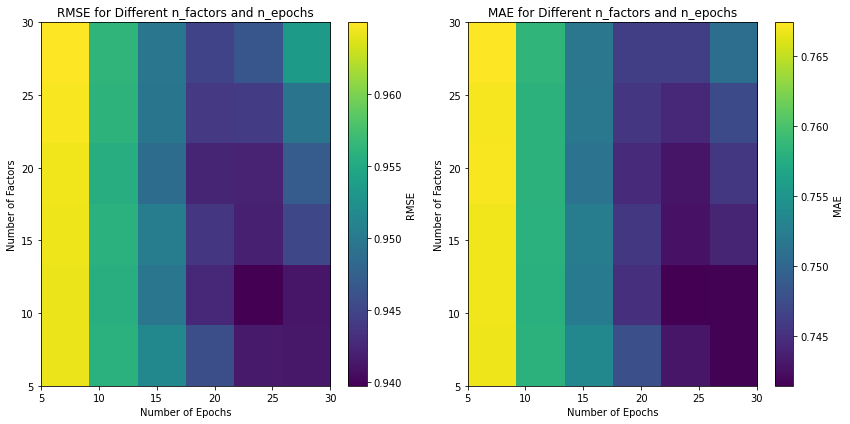

In [38]:
# SVD with bias
test_with_different_params(SVDBias, 30, 30)

Done computing SVDPlusPlus with 5 factors & 5 epochs.
Done computing SVDPlusPlus with 5 factors & 10 epochs.
Done computing SVDPlusPlus with 5 factors & 15 epochs.
Done computing SVDPlusPlus with 5 factors & 20 epochs.
Done computing SVDPlusPlus with 5 factors & 25 epochs.
Done computing SVDPlusPlus with 5 factors & 30 epochs.
Done computing SVDPlusPlus with 10 factors & 5 epochs.
Done computing SVDPlusPlus with 10 factors & 10 epochs.
Done computing SVDPlusPlus with 10 factors & 15 epochs.
Done computing SVDPlusPlus with 10 factors & 20 epochs.
Done computing SVDPlusPlus with 10 factors & 25 epochs.
Done computing SVDPlusPlus with 10 factors & 30 epochs.
Done computing SVDPlusPlus with 15 factors & 5 epochs.
Done computing SVDPlusPlus with 15 factors & 10 epochs.
Done computing SVDPlusPlus with 15 factors & 15 epochs.
Done computing SVDPlusPlus with 15 factors & 20 epochs.
Done computing SVDPlusPlus with 15 factors & 25 epochs.
Done computing SVDPlusPlus with 15 factors & 30 epochs.
D

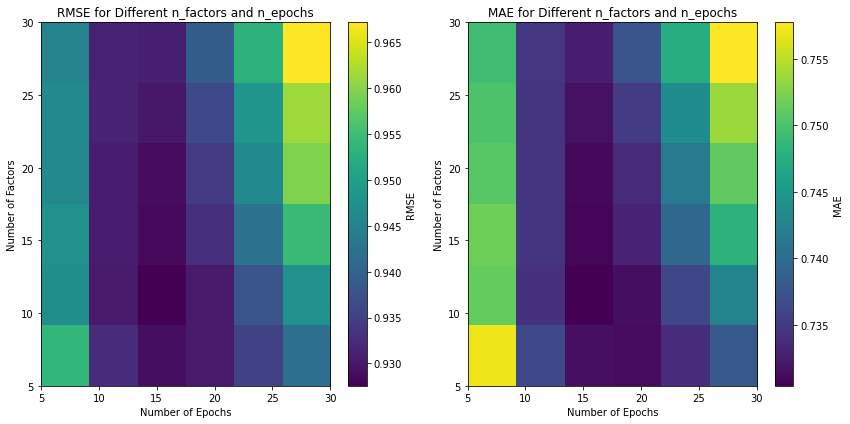

In [39]:
# SVD++
test_with_different_params(SVDPlusPlus, 30, 30)

Done computing VanillaMF with 5 factors & 5 epochs.
Done computing VanillaMF with 5 factors & 10 epochs.
Done computing VanillaMF with 5 factors & 15 epochs.
Done computing VanillaMF with 5 factors & 20 epochs.
Done computing VanillaMF with 5 factors & 25 epochs.
Done computing VanillaMF with 5 factors & 30 epochs.
Done computing VanillaMF with 10 factors & 5 epochs.
Done computing VanillaMF with 10 factors & 10 epochs.
Done computing VanillaMF with 10 factors & 15 epochs.
Done computing VanillaMF with 10 factors & 20 epochs.
Done computing VanillaMF with 10 factors & 25 epochs.
Done computing VanillaMF with 10 factors & 30 epochs.
Done computing VanillaMF with 15 factors & 5 epochs.
Done computing VanillaMF with 15 factors & 10 epochs.
Done computing VanillaMF with 15 factors & 15 epochs.
Done computing VanillaMF with 15 factors & 20 epochs.
Done computing VanillaMF with 15 factors & 25 epochs.
Done computing VanillaMF with 15 factors & 30 epochs.
Done computing VanillaMF with 20 fact

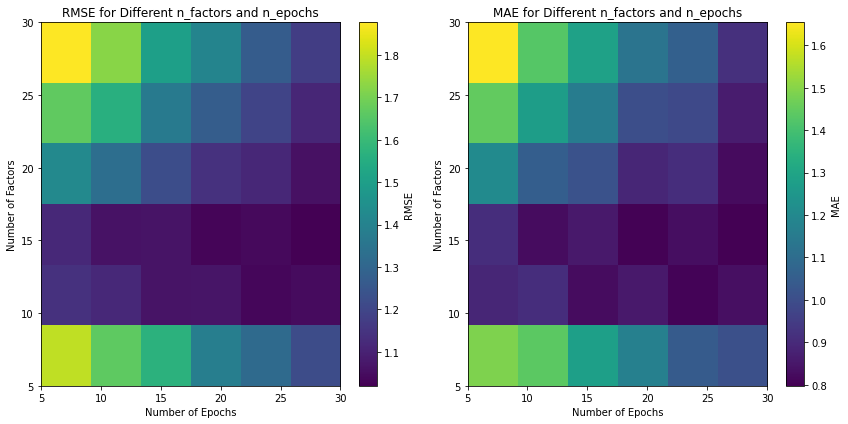

In [40]:
# VanillaMF
test_with_different_params(VanillaMF, 30, 30)

Thanks to this fine-tuning process and the figures plotted above, we can create new instances of these 3 best algorithms so far and compare the results.

In [41]:
svd_bias = SVDBias(n_factors=10, n_epochs=25)
svd_bias.train()
svd_bias.test()

svd_plus_plus = SVDPlusPlus(n_factors=10, n_epochs=15)
svd_plus_plus.train()
svd_plus_plus.test()

vanilla_mf = VanillaMF(n_factors=15, n_epochs=30)
vanilla_mf.train()
vanilla_mf.test()

pd.concat([
    svd_bias.evaluate(),
    svd_plus_plus.evaluate(),
    vanilla_mf.evaluate()
], ignore_index=True)

,model,rmse,mae,Factors,Epochs,Biased
0,SVDBias,0.939768,0.741442,10,25,Yes
1,SVDPlusPlus,0.927567,0.730417,10,15,No
2,VanillaMF,1.019864,0.797556,15,30,No


Thanks to this fine-tuning process, we have been able to enhance the score of SVD with bias and SVD++. The score of VanillaMF remains the same.
Now, SVD++ gets a better metrics when fully optimized than SVD with bias, which makes it our best choice for predictions if we consider those metrics first.

| Recommender                                    | Old RMSE     | Old MAE      | New RMSE | New MAE | Old rank | New Rank |
|------------------------------------------------|----------|----------|----------|----------|----------|----------|
| SVD++                                          | 0.986530 | 0.771494 | 0.927567 | 0.730417 | 2    | 1
| SVD with bias                                  | 0.974461 | 0.764493 | 0.939768 | 0.741442 | 1    | 2

# Conclusion

Our comparison of different recommendation systems led us to the conclusion that, firstly, matrix factorization algorithms appear to be more efficient when looking at the RMSE & MAE metrics and, secondly, our efforts to implement the metadata in the decision process whenever possible do not improve these metrics. Finally, those metrics can be enhanced by fine-tuning the epochs & factors of those algorithms.
Given this statement, we would prefer to use SVD++ to recommend a movie to a user. In the case of our example user, the next movie he or she is likely to watch is "The Patriot".